In [30]:
import numpy as np
from matplotlib import pyplot, image as mpimage

In [38]:
import matplotlib.colors as mcolors
mcolors.to_rgb("yellowgreen")

(0.6039215686274509, 0.803921568627451, 0.19607843137254902)

/var/folders/2z/4fqb8tw567gg9xt41v3t00x40000gp/T/ipykernel_55432/217690377.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


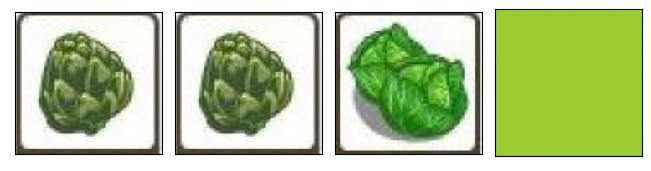

In [41]:
empty_resource = np.full((85, 85, 3), fill_value=mcolors.to_rgb("yellowgreen"))

def render(resources, market):
    n_resources = len(resources)
    figure, axes = pyplot.subplots(
        1, n_resources, constrained_layout=True,
        subplot_kw={"facecolor": "green", "xticks": [], "yticks": []},
        gridspec_kw={'height_ratios': (1,)}
    )

    # Sub-plot the icon image for each of the resources
    for i in range(n_resources):
        axis, resource = axes.flat[i], resources[i]

        if resource != -1:
            axis.imshow(mpimage.imread(market[resource]["icon"]))
        else:
            axis.imshow(empty_resource)



    figure.show()


render(
    [1, 1, 3, -1],
    [
        {"icon": "../data/images/seeds/acorn-squash.jpg"},
        {"icon": "../data/images/seeds/artichoke.jpg"},
        {"icon": "../data/images/seeds/black-berry.jpg"},
        {"icon": "../data/images/seeds/cabbage.jpg"},
    ]
)

In [ ]:
import operator
import queue
import random
import sched
from dataclasses import dataclass
from functools import reduce, singledispatchmethod
from typing import Any, Callable, Optional

import gymnasium as gym
import numpy as np
from numpy.typing import NDArray

GridShape = tuple[int, int]


In [ ]:
class DiscreteVocabulary(gym.spaces.Discrete):
    def __init__(self, vocab: list[str], **kwargs):
        super().__init__(len(vocab), **kwargs)
        self.vocab = list(sorted(vocab))

    def sample(self, mask: Optional[Any] = None) -> str:
        i = super().sample(mask)
        return self.vocab[i]

    @singledispatchmethod
    def contains(self, x) -> bool:
        raise NotImplementedError()

    @contains.register(str)
    def contains_str(self, x):
        return x in self.vocab

    @contains.register(int)
    def contains_int(self, x):
        return super().contains(x)

    def __getitem__(self, i: int):
        return self.vocab[i]

    def __iter__(self):
        return iter(self.vocab)


@gym.spaces.utils.flatten.register(DiscreteVocabulary)
def _flatten_discrete_vocabulary(space: DiscreteVocabulary, x: str) -> NDArray[np.int64]:
    i = space.vocab.index(x)
    onehot = np.zeros(space.n, dtype=space.dtype)
    onehot[i] = 1
    return onehot


@gym.spaces.utils.unflatten.register(DiscreteVocabulary)
def _unflatten_discrete(space: DiscreteVocabulary, x: NDArray[np.int64]) -> str:
    i = int(np.nonzero(x)[0][0])
    return space.vocab[i]



In [ ]:
@dataclass
class Product:
    name: str
    cost: int
    reward: int
    grow_time: int


class MarketPlace(DiscreteVocabulary):
    def __init__(self, products: list[Product]):
        super().__init__([p.name for p in products])
        self.table = {p.name: p for p in products}

    @property
    def costs(self) -> NDArray:
        """Created a normalized cost function (array) indexed on product"""
        return np.array([self.table[p].cost for p in self.vocab])

    def cost(self, action: str, time: int):
        return self.product[action].cost

    @property
    def revenues(self) -> NDArray:
        """Created a normalized cost function (array) indexed on product"""
        return np.array([self.table[p].revenue for p in self.vocab])

    def revenue(self, action: str, time: int):
        return self.product[action].revenue

    @property
    def grow_times(self) -> NDArray:
        """Created a normalized cost function (array) indexed on product"""
        return np.array([self.table[p].grow_time for p in self.vocab])

    def grow_time(self, action: str, time: int):
        return self.product[action].grow_time

    def sample(self, mask: Optional[Any] = None) -> str:
        key = super().sample(mask)
        return self.table[key]

    def __getitem__(self, key: str):
        return self.table[key]

    def __len__(self):
        return len(self.vocab)


In [ ]:
class DelayedRewards(queue.PriorityQueue):
    def __init__(self, marketplace: MarketPlace, size: int = -1):
        super().__init__(size)
        self.marketplace = marketplace

    def enter(self, t: int, delay: int, action: str) -> float:
        # Try to schedule a product, returning the upfront cost
        # of scheduling
        product = self.marketplace[action]
        try:
            self.put((t + delay, action))
            return product.cost

        # Ignore actions when you can't plant. Alternatively,
        # we can drop a crop
        except queue.Full():
            return 0

    def step(self, t: int = None):
        """Harvest all scheduled products that have priority """
        finished, reward = False, 0
        if self.empty(): return reward

        while not finished:
            # Check the next priority product
            t_scheduled, action = self.get()

            # If it's ready,
            if t_scheduled <= t:
                reward += self.marketplace[action].reward

            else:
                self.put((t_scheduled, action))
                finished = True

        return reward

    def view(self, t: int):
        """View an observation of the delayed rewards queue"""
        return np.array([
            (self.marketplace[product], priority - t)
            for (priority, product) in self.queue
        ])


In [1]:
class RLVille(gym.Env):
    def __init__(
        self,
        shape: GridShape,
        products: list[Product],
        seed: int | None = None
    ):
        # Keep a GridWorld around for rendering the current state
        self.grid = np.full(shape, fill_value=-1)
        self.d_resources = reduce(operator.mul, shape)
        self.d_products = len(products)

        #
        self.t = 0
        self.balance = 500
        self.resources = DelayedRewards(self.d_resources)
        self.timeout = random.randint(1_000, 10_000)

        # The Action Space of our RLVille environment is a choice of Products
        # in a MarketPlace, adding a special "noop" action so that the agent always
        # has a choice available to it with (cost, reward, grow_time) = (0, 0, 0).
        # This is so that the agent can always make a choice at every time
        # step.
        self._actions = {"noop": (0, 0, 0), "strawberries": (10, 35, 4)}
        self.action_space: MarketPlace = MarketPlace([
            Product(name, *props) for name, props in self._actions
        ])

        # The Observation Space of our RLVille environment is a current balance
        # and a Box containing remaining grow times for all resources.
        self.observation_space = gym.spaces.Dict({
            "balance": gym.spaces.Box(low=0, high=np.inf, seed=seed),
            "resources": gym.spaces.Box(
                low=np.full(self.d_resources, fill_value=0),
                high=np.full(self.d_resources, fill_value=np.inf),
                seed=seed
            ),
            "timers": gym.spaces.Box(
                low=np.full(self.d_resources, fill_value=0),
                high=np.full(self.d_resources, fill_value=np.inf),
                seed=seed
            ),
        })

    @property
    def shape(self):
        return self.d_resources, self.d_products

    def actions(self):
        """
        :returns:
            A mask of available actions we can take given the current value
            of our bank account.
        """
        return np.argwwhere(self.action_space.costs <= self.balance).tolist()

    def step(self, action: str):
        self.t += 1

        # Harvest anything off the queue that can be harvested and compute
        # the revenue
        reward = self.resources.step(self.t)

        # Get the product from our vocabulary
        A = self.action_space[action]
        cost = self.resources.enter(self.t, A.delay, A)

        # The episode
        term = self.t >= self.timeout

        return self.resources.view(), cost + reward, term, False, {}

    def reset(self, **kwargs):
        self.balance = 500
        self.resources = queue.PriorityQueue(maxsize=self.d_resources)
        self.timeout = random.randint(1_000, 10_000)

    def render(self, mode="human"):
        pass


NameError: name 'gym' is not defined